In [2]:
import warnings
warnings.filterwarnings('ignore')

#Python Native Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from timeit import default_timer as timer

#Spark Libraries
import pyspark.sql.functions as fn
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StringType, StructField, StructType, TimestampType, IntegerType

#ML Libraries
from fbprophet import Prophet
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, PCA, OneHotEncoderEstimator, StringIndexer

In [3]:
#Initializing or getting spark session
spark = SparkSession.builder.appName("COVID Project")\
                            .master("local[*]")\
                            .config('spark.sql.execution.arrow.enable', 'true').getOrCreate()

### Reading and Preprocessing Dataset

In [4]:
#Dataset is read directly from the url using Pandas read_csv function
dataset = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv")

In [5]:
#As data column can be in any datatype, it might create issues while converting into Spark Dataframes
#So, converting all columns in String Datatype
dataset[['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']] = dataset[['dateRep', 'day', 'month', 
       'year', 'cases', 'deaths', 'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']].astype(str)

In [6]:
#Converting Pandas df to Spark Dataframe
data_df = spark.createDataFrame(dataset)

In [7]:
#Number of records in dataset
data_df.count()

33059

In [8]:
#Countries for which data is present in dataset
data_df.select("countriesAndTerritories").distinct().count()

210

In [9]:
#Renaming columns as per our need
data_df_renamed = data_df.withColumnRenamed("dateRep", "date")\
                         .withColumnRenamed("countriesAndTerritories", "country")\
                         .withColumnRenamed("geoId","countryGeoId")\
                         .withColumnRenamed("countryterritoryCode", "countryCode")\
                         .withColumnRenamed("popData2019", "totalPopulation")\
                         .withColumnRenamed("continentExp", "continent")\
                         .withColumnRenamed("Cumulative_number_for_14_days_of_COVID-19_cases_per_100000", "casesPer100k")

In [10]:
#Converting datatypes of columns to appropriate datatype as per its column value
data_df_types = data_df_renamed\
                    .withColumn("date", fn.from_unixtime(fn.unix_timestamp("date","dd/MM/yyyy")).cast("Date"))\
                    .withColumn("day", fn.col("day").cast("Integer"))\
                    .withColumn("month", fn.col("month").cast("Integer"))\
                    .withColumn("cases", fn.col("cases").cast("Integer"))\
                    .withColumn("year", fn.col("year").cast("Integer"))\
                    .withColumn("deaths", fn.col("deaths").cast("Integer"))\
                    .withColumn("country", fn.col("country").cast("String"))\
                    .withColumn("countryGeoId", fn.col("countryGeoId").cast("String"))\
                    .withColumn("totalPopulation", fn.col("totalPopulation").cast("Integer"))\
                    .withColumn("continent", fn.col("continent").cast("String"))\
                    .withColumn("casesPer100k", fn.round(fn.col("casesPer100k"), 2).cast("Double"))

### Visualization of Dataset

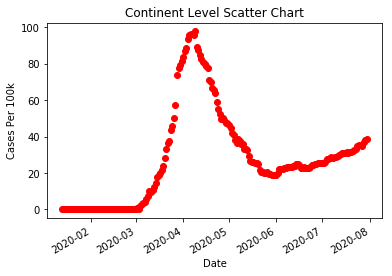

In [11]:
#Looking at Continent Wise Trend
data_df_aggr = data_df_types.groupBy("continent","date")\
                            .agg(fn.round(fn.avg("casesPer100k"), 2).alias("casesPer100k"))

data_filter = data_df_aggr.where(fn.col("continent") == "Europe")

pd_df = data_filter.toPandas()

plt.xlabel("Date")
plt.ylabel("Cases Per 100k")
plt.title("Continent Level Scatter Chart")
plt.plot(pd_df["date"], pd_df["casesPer100k"],"ro")
plt.gcf().autofmt_xdate()
plt.savefig("output/Chart1.png")
plt.show()

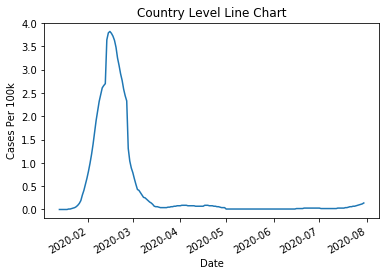

In [12]:
#Looking at Country wise trend
data_df_filter = data_df_types.where((fn.col("country") == "China"))

pd_df = data_df_filter.toPandas()

plt.plot(pd_df["date"], pd_df["casesPer100k"])
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Cases Per 100k")
plt.title("Country Level Line Chart")
plt.savefig("output/Chart2.png")
plt.show()

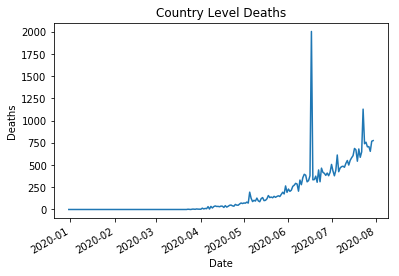

In [13]:
#Looking at Country wise trend for deaths
data_df_filter = data_df_types.where((fn.col("country") == "India"))

pd_df = data_df_filter.select("date", "deaths").toPandas()

plt.plot(pd_df["date"], pd_df["deaths"])
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.title("Country Level Deaths")
plt.savefig("output/Chart3.png")
plt.show()

### Analyzing Data

In [14]:
#Cumulative average is taken to get better results
#Firstly, getting dailyCases column using casesPer100k * (totalPopulation/1000000)
data_new = data_df_types.withColumn("dailyCases", 
                                    (fn.col("casesPer100k")*(fn.col("totalPopulation")/1000000)).cast("Integer"))

In [15]:
#New cases, Deaths
max_date = data_new.agg(fn.max("date")).collect()[0][0]

data_result_1 = data_new.where(fn.col("date") == max_date)\
                        .agg(fn.sum("deaths").alias("New Deaths"), 
                             fn.sum("cases").cast("Integer").alias("New Cases"))

data_result_1.show()

+----------+---------+
|New Deaths|New Cases|
+----------+---------+
|      6714|   293699|
+----------+---------+



In [16]:
#Total deaths, total cases till now
data_result_2 = data_new.agg(fn.sum("deaths").alias("Total Deaths"), fn.sum("cases").alias("Total Cases"))

data_result_2.show()

+------------+-----------+
|Total Deaths|Total Cases|
+------------+-----------+
|      666857|   17005983|
+------------+-----------+



In [17]:
#Getting top 10 countries with respect to total number of cases
data_result_3 = data_new.groupBy("country")\
                        .agg(fn.sum("dailyCases").alias("Total Cases"))\
                        .orderBy("Total Cases", ascending = False)\
                        .limit(10)

data_result_3.show(truncate = False)

+------------------------+-----------+
|country                 |Total Cases|
+------------------------+-----------+
|United_States_of_America|5603856    |
|Brazil                  |3165905    |
|India                   |1786839    |
|Russia                  |1109625    |
|South_Africa            |561928     |
|Peru                    |517218     |
|Mexico                  |513685     |
|Chile                   |472941     |
|United_Kingdom          |416968     |
|Iran                    |395690     |
+------------------------+-----------+



In [18]:
#Getting top 3 countries as per month with respect to total cases happened in that month
data_temp_4_1 = data_new.groupBy("month", "year", "country")\
                        .agg(fn.sum("dailyCases").alias("monthlyCasesCount"))

data_temp_4_2 = data_temp_4_1.na.drop()

window = Window.partitionBy("year", "month").orderBy(fn.desc("monthlyCasesCount"))

data_result_4 = data_temp_4_2.withColumn("rank", fn.rank().over(window))\
                             .where("rank <= 3")\
                             .orderBy(fn.desc("year"), fn.desc("month"), "rank")

data_result_4.show(15, False)

+-----+----+------------------------+-----------------+----+
|month|year|country                 |monthlyCasesCount|rank|
+-----+----+------------------------+-----------------+----+
|7    |2020|United_States_of_America|2320959          |1   |
|7    |2020|Brazil                  |1564734          |2   |
|7    |2020|India                   |1152392          |3   |
|6    |2020|Brazil                  |1102222          |1   |
|6    |2020|United_States_of_America|1002645          |2   |
|6    |2020|India                   |443702           |3   |
|5    |2020|United_States_of_America|1077369          |1   |
|5    |2020|Brazil                  |428155           |2   |
|5    |2020|Russia                  |389049           |3   |
|4    |2020|United_States_of_America|1112362          |1   |
|4    |2020|Spain                   |205472           |2   |
|4    |2020|United_Kingdom          |173060           |3   |
|3    |2020|Italy                   |93153            |1   |
|3    |2020|United_State

In [19]:
#Getting maximum number of cases per each month by casesPer100k *  totalpopulation/100k
data_result_5 = data_new.groupBy("year", "month")\
                        .agg(fn.sum("dailyCases").alias("monthlyTotalCases"))\
                        .orderBy("monthlyTotalCases", ascending = False)\
                        .na.drop()

data_result_5.show()

+----+-----+-----------------+
|year|month|monthlyTotalCases|
+----+-----+-----------------+
|2020|    7|          8676429|
|2020|    6|          5394066|
|2020|    5|          3741741|
|2020|    4|          3044653|
|2020|    3|           526174|
|2020|    2|           104028|
|2020|    1|             3601|
+----+-----+-----------------+



In [20]:
#Month where maximum deaths happened
data_result_6 = data_new.groupBy("year", "month")\
                        .agg(fn.sum("deaths").alias("monthlyDeaths"))\
                        .orderBy("monthlyDeaths", ascending = False)\
                        .na.drop()

data_result_6.show()

+----+-----+-------------+
|year|month|monthlyDeaths|
+----+-----+-------------+
|2020|    4|       189241|
|2020|    7|       161539|
|2020|    5|       141737|
|2020|    6|       135820|
|2020|    3|        35599|
|2020|    2|         2708|
|2020|    1|          213|
|2019|   12|            0|
+----+-----+-------------+



In [21]:
#Peak month cases for each country
data_temp_7_1 = data_new.groupBy("country", "month", "year")\
                            .agg(fn.sum("dailyCases").alias("monthlyCases"))

data_temp_7_2 = data_temp_7_1.na.drop()

window = Window.partitionBy("country").orderBy(fn.desc("monthlyCases"))

data_result_7 = data_temp_7_2.withColumn("Rank", fn.rank().over(window))\
                             .where("rank <= 3")\
                             .orderBy("country", "rank")

data_result_7.show(15, False)

+-----------+-----+----+------------+----+
|country    |month|year|monthlyCases|Rank|
+-----------+-----+----+------------+----+
|Afghanistan|6    |2020|26280       |1   |
|Afghanistan|5    |2020|12659       |2   |
|Afghanistan|7    |2020|9430        |3   |
|Albania    |7    |2020|3328        |1   |
|Albania    |6    |2020|1438        |2   |
|Albania    |4    |2020|710         |3   |
|Algeria    |7    |2020|18333       |1   |
|Algeria    |5    |2020|7244        |2   |
|Algeria    |6    |2020|5508        |3   |
|Andorra    |4    |2020|757         |1   |
|Andorra    |3    |2020|145         |2   |
|Andorra    |6    |2020|116         |3   |
|Angola     |7    |2020|838         |1   |
|Angola     |6    |2020|168         |2   |
|Angola     |5    |2020|35          |3   |
+-----------+-----+----+------------+----+
only showing top 15 rows



### Persisting Output Results

In [22]:
#Persisting all the generated results in a csv file
data_result_1.write.csv("output/data_result_1.csv",mode = "overwrite", header = True)
data_result_2.write.csv("output/data_result_2.csv",mode = "overwrite", header = True)
data_result_3.write.csv("output/data_result_3.csv",mode = "overwrite", header = True)
data_result_4.write.csv("output/data_result_4.csv",mode = "overwrite", header = True)
data_result_5.write.csv("output/data_result_5.csv",mode = "overwrite", header = True)
data_result_6.write.csv("output/data_result_6.csv",mode = "overwrite", header = True)
data_result_7.write.csv("output/data_result_7.csv",mode = "overwrite", header = True)

### Future Prediction

In [23]:
#Getting only columns needed for Forecast
start = timer()
data_input = data_new.select("country", fn.col("date").cast("TimeStamp").alias("ds"), 
                            fn.col("dailyCases").alias("y"))

In [24]:
#Declaring schema for Pandas UDF function
schema = StructType([
        StructField("country", StringType(), True),
        StructField("ds", TimestampType(), True),
        StructField("y", IntegerType(), True)
    ])

In [25]:
#Making a Pandas UDF function which will be called from Spark Dataframe
#This function will generate forecast for each country
@pandas_udf(returnType = schema, functionType = PandasUDFType.GROUPED_MAP)
def forecast_store_item(input_pd):

    #Initializing Prophet model with appropriate Parameters
    model = Prophet(
        interval_width=0.5,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )
    
    # Training our model with data
    model.fit(input_pd)

    #Generating future data using 'make_future_dataframe' function of Prophet model
    future_pd = model.make_future_dataframe(
        periods=90,
        freq='d',
        include_history=False
    )

    #Predicting data for next 90 days and selecting only needful columns
    forecast_pd = model.predict(future_pd)[["ds", "yhat"]]
    
    #renaming columns as per need
    result_pd = forecast_pd[["ds","yhat"]].rename(columns = {'yhat':'y'})
    
    #getting the name of country for which function is called
    country = input_pd.values.tolist()[0][0]
    
    #generating country column in predicted Dataframe with value as generated country name
    result_pd["country"] = country
    
    #Finally unioning both(historical data, predicted data) the dataframes to form final dataframe
    final_pd = pd.concat([input_pd, result_pd])
    
    
    #returning final dataframe
    return final_pd

In [26]:
#Grouping the data data by country, so pandas_udf will be called for each country 
#So, model training will be ran in parallel for each country
#Pandas UDF will be called country wise, so each call will contain data for only one country
results = data_input.na.drop()\
            .groupBy('country')\
            .apply(forecast_store_item)

In [27]:
#Getting sample data from results which contains data for a particular country and last 30 days to future 7 days
results_sample = results.where("country == 'Italy' and ds between DATE_ADD(now(), -30) and DATE_ADD(now(), 7)")

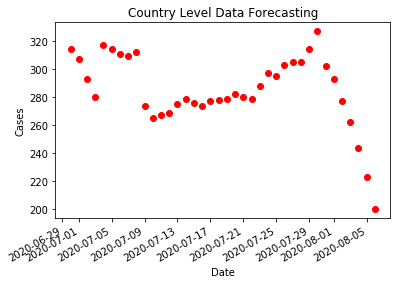

In [28]:
#Visualizing the data
results_pd = results_sample.toPandas()

plt.plot(results_pd["ds"], results_pd["y"], "ro")
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("Country Level Data Forecasting")
plt.savefig("output/Chart4.png")
plt.show()

In [29]:
#Persisting the results in a csv file
#results.write.csv("output/forecast.csv", mode = "overwrite", header = True)

#If only one csv file is to be generated, coalesce will reduce number of partitions to 1
results.coalesce(1).write.csv("output/forecast.csv", mode = "overwrite", header = True) 
end = timer()
print(end - start)

1215.8692357259997


### Applying Random Forest on Dataset

In [30]:
#Selecting necessary columns for Machine Learning model
data_ml = data_new.select("day", "month", "year", "country", "totalPopulation","cases")

In [31]:
#As country column is in String format, we have to convert it to numeric form
#So, firstly we will index the country column
start = timer()
stringIndexer = StringIndexer(inputCol="country", outputCol="country_index")
indexedDF = stringIndexer.fit(data_ml).transform(data_ml)

In [32]:
#Now the indexed country column will be encoded using One Hot Encoder
oneHotEncoder = OneHotEncoderEstimator(inputCols = ["country_index"], outputCols = ["country_vector"])
processedDF = oneHotEncoder.fit(indexedDF).transform(indexedDF)

In [33]:
#Taking feature columns in a list
featureCols = processedDF.drop("cases","country").columns

In [34]:
#As Spark takes only one column as input, we will merge all columns in one column using Vector Assembler
assembler = VectorAssembler()\
              .setInputCols(featureCols)\
              .setOutputCol("features")

finalDF = assembler.setHandleInvalid("skip").transform(processedDF)

In [35]:
#Splitting the data in training and testing sets
training, test = finalDF.randomSplit([0.8, 0.2])

In [36]:
#Initializing Random Forest Model
rfModel = RandomForestRegressor()\
            .setLabelCol("cases")\
            .setFeaturesCol("features")

In [37]:
#Initializing Parameter Grid with appropriate features for Hyper Parameter Tuning
paramGrid = ParamGridBuilder()\
                  .addGrid(rfModel.maxDepth, [20, 30])\
                  .addGrid(rfModel.numTrees, [10, 30])\
                  .addGrid(rfModel.maxBins, [250, 350])\
                  .build()

In [38]:
#Initializing Cross Valitor Model to train our parameterized Random Forest Model
cv = CrossValidator()\
          .setEstimator(rfModel)\
          .setEstimatorParamMaps(paramGrid)\
          .setEvaluator(RegressionEvaluator().setLabelCol("cases"))

In [39]:
#Training our final model
rfFitted = cv.fit(training)

In [40]:
#Generating predictions from test dataset
predictions = rfFitted.transform(test)

In [41]:
#Evaluating our Random Forest Model
evaluator = RegressionEvaluator(
                labelCol="cases", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

end = timer()
print(end-start)

Root Mean Squared Error (RMSE) on test data = 1312.72
1275.1401337060006


In [42]:
#Visualizing the predicted data
predictions.where("country == 'Germany'").show()

+---+-----+----+-------+---------------+-----+-------------+----------------+--------------------+------------------+
|day|month|year|country|totalPopulation|cases|country_index|  country_vector|            features|        prediction|
+---+-----+----+-------+---------------+-----+-------------+----------------+--------------------+------------------+
|  1|    2|2020|Germany|       83019213|    2|         23.0|(209,[23],[1.0])|(214,[0,1,2,3,4,2...| 138.7239944233705|
|  2|    7|2020|Germany|       83019213|  503|         23.0|(209,[23],[1.0])|(214,[0,1,2,3,4,2...| 677.1145769398082|
|  3|    5|2020|Germany|       83019213|  793|         23.0|(209,[23],[1.0])|(214,[0,1,2,3,4,2...| 1025.411654758173|
|  4|    2|2020|Germany|       83019213|    2|         23.0|(209,[23],[1.0])|(214,[0,1,2,3,4,2...| 138.5942403610077|
|  4|    6|2020|Germany|       83019213|  394|         23.0|(209,[23],[1.0])|(214,[0,1,2,3,4,2...| 607.4233752832592|
|  5|    1|2020|Germany|       83019213|    0|         2

In [46]:
#Persisting predictions data in csv files
predictions.drop("country_vector", "features").coalesce(1).write.csv("output/predictions.csv", mode = "overwrite", header = True) 